# TorchVision 0.3 DEEPLAB Finetuning

For this notebook, we will be finetuning a pre-trained DEEPLAB model in the Crack Forest Dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

This notebook has been inspired from both following links: [link 1](https://medium.com/technovators/semantic-segmentation-using-deeplabv3-ce68621e139e) and [link 2](https://expoundai.wordpress.com/2019/08/30/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch/)

In [ ]:
#we just cloned the repo in order to access the data easily and install the deps !

In [ ]:
!git clone https://github.com/msminhas93/DeepLabv3FineTuning.git

Cloning into 'DeepLabv3FineTuning'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 337 (delta 3), reused 21 (delta 2), pack-reused 309
Receiving objects: 100% (337/337), 4.08 MiB | 40.20 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
cd /content/DeepLabv3FineTuning

/content/DeepLabv3FineTuning


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-l8bcj9b6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-l8bcj9b6
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266250 sha256=19144fd56140e51a4c4de10b1137159e9140627c6a1f35f2ee10a88ba810e976
  Stored in directory: /tmp/pip-ephem-wheel-cache-cwc5dp1q/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


### Writing a custom dataset for Crack Forest Dataset

Let's write a dataset for the Crack Forest dataset. The dataset was downloaded on my drive.

In [ ]:
!pip install PyDrive

In [ ]:

"""
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#2. Get the file
downloaded = drive.CreateFile({'id':"1gvSzlpmGJ8TGph7m8uO5bOXLUU6HL3c6"})   # replace the id with id of file you want to access
downloaded.GetContentFile('headsegmentation_dataset_ccncsa.zip')
"""

In [ ]:
"""
%%shell
unzip /content/CrackForest.zip
"""

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
CrackForest/
  Images/
    001.png
    002.png
    003.png
    004.png
    ...
  Masks/
    001_label.png
    002_label.png
    003_label.png
    004_label.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [ ]:
cd /content/DeepLabv3FineTuning

/content/DeepLabv3FineTuning


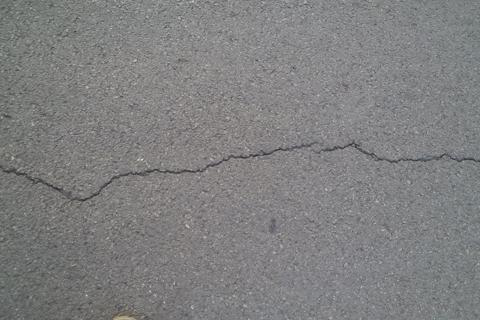

In [ ]:
from PIL import Image
Image.open('CrackForest/Images/001.jpg')

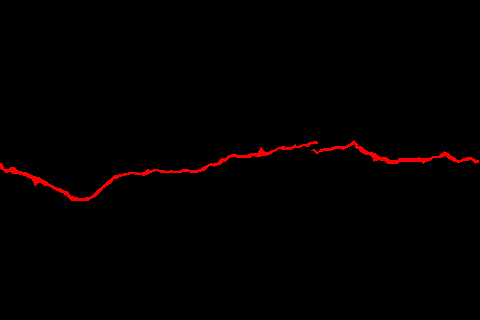

In [ ]:
mask = Image.open('CrackForest/Masks/001_label.PNG')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # Crack is red
])
mask

#Data Loader
We use Torch Dataloader for loading the dataset and then apply some transformations that we are going to define by ourselves since our dataset returns a dictionary which will not work with the standard transforms provided by Torchvision 

#Try to read the images with PIL yel 7mara ! I think that would solve the problem wallah ! because no transforms would be applied and would be compatible with tens formats !!!!!!

In [ ]:
from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset


class SegmentationDataset(VisionDataset):
    """A PyTorch dataset for image segmentation task.
    The dataset is compatible with torchvision transforms.
    The transforms passed would be applied to both the Images and Masks.
    """
    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "grayscale") -> None:
        """
        Args:
            root (str): Root directory path.
            image_folder (str): Name of the folder that contains the images in the root directory.
            mask_folder (str): Name of the folder that contains the masks in the root directory.
            transforms (Optional[Callable], optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.ToTensor`` for images. Defaults to None.
            seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
            fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
            subset (str, optional): 'Train' or 'Test' to select the appropriate set. Defaults to None.
            image_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'rgb'.
            mask_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'grayscale'.
        Raises:
            OSError: If image folder doesn't exist in root.
            OSError: If mask folder doesn't exist in root.
            ValueError: If subset is not either 'Train' or 'Test'
            ValueError: If image_color_mode and mask_color_mode are either 'rgb' or 'grayscale'
        """
        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder
        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        if image_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{image_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )
        if mask_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode

        if not fraction:
            self.image_names = sorted(image_folder_path.glob("*"))
            self.mask_names = sorted(mask_folder_path.glob("*"))
        else:
            if subset not in ["Train", "Test"]:
                raise (ValueError(
                    f"{subset} is not a valid input. Acceptable values are Train and Test."
                ))
            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*")))
            self.mask_list = np.array(sorted(mask_folder_path.glob("*")))
            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices]
                self.mask_list = self.mask_list[indices]
            if subset == "Train":
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[
                    int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            if self.image_color_mode == "rgb":
                image = image.convert("RGB")
            elif self.image_color_mode == "grayscale":
                image = image.convert("L")
            mask = Image.open(mask_file)
            if self.mask_color_mode == "rgb":
                mask = mask.convert("RGB")
            elif self.mask_color_mode == "grayscale":
                mask = mask.convert("L")
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
seg_dataset = SegmentationDataset("CrackForest", "Images", "Masks", transforms=transforms.Compose([transforms.ToTensor()]))
seg_dataloader = DataLoader(seg_dataset, batch_size=32, shuffle=False, num_workers=8)
samples = next(iter(seg_dataloader))
# Display the image and mask tensor shape
# We see the tensor size is correct bxcxhxw, where b is batch size, c is number of channels, h is height, w is width
display(samples['image'].shape,
samples['mask'].shape)

torch.Size([32, 3, 320, 480])

torch.Size([32, 1, 320, 480])

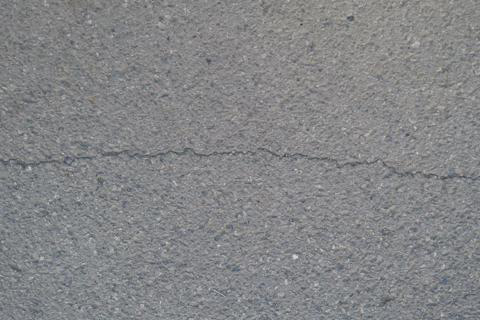

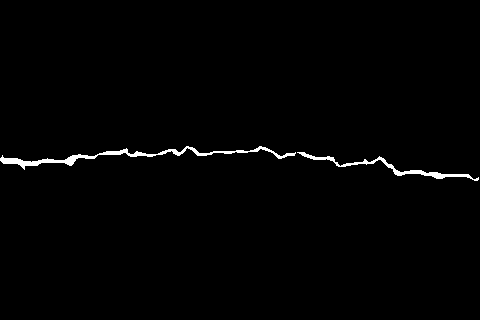

In [ ]:

img = transforms.ToPILImage()(samples['image'][5])
mask = transforms.ToPILImage()(samples['mask'][5])

display(img, mask)

don't run this cell!

# Define Our Baby Model

In [ ]:
""" DeepLabv3 Model download and change the head for your prediction"""
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models



def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Tanh activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

# Prepare the Garden To play!

In [ ]:
import csv
import copy
import time
from tqdm import tqdm
import torch
import numpy as np
import os


def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            #print(dataloaders[phase].shape())
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                print("inputs__zina",inputs.shape)
                print("masks__zina",masks.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def get_dataloader_single_folder(data_dir: str,
                                 image_folder: str = 'Images',
                                 mask_folder: str = 'Masks',
                                 fraction: float = 0.2,
                                 batch_size: int = 4):
    """Create train and test dataloader from a single directory containing
    the image and mask folders.
    Args:
        data_dir (str): Data directory path or root
        image_folder (str, optional): Image folder name. Defaults to 'Images'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Masks'.
        fraction (float, optional): Fraction of Test set. Defaults to 0.2.
        batch_size (int, optional): Dataloader batch size. Defaults to 4.
    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """
    data_transforms = transforms.Compose([transforms.ToTensor()])

    image_datasets = {
        x: SegmentationDataset(data_dir,
                               image_folder=image_folder,
                               mask_folder=mask_folder,
                               seed=100,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8)
        for x in ['Train', 'Test']
    }
    return dataloaders

# Put Everything Together Guys!

In [ ]:
mkdir CFEXP1

In [ ]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score
import torch

#experience directory

bpath = '/content/DeepLabv3FineTuning/CFEXP1'
#data directory
data_dir = '/content/DeepLabv3FineTuning/CrackForest'
#data_dir = '/content/CrackForest-dataset-master'
#epochs
#epochs = 100
epochs =25
#batchsize
batchsize = 4


# Create the deeplabv3 resnet101 model which is pretrained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
model = createDeepLabv3()
model.train()
# Create the experiment directory if not present
if not os.path.isdir(bpath):
    os.mkdir(bpath)


# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Specify the evalutation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

#Images/Masks!
# Create the dataloader
#dataloaders = get_dataloader_single_folder(data_dir, imageFolder='Images', maskFolder='Masks', fraction=0.2, batch_size=batchsize)
  # Create the dataloader
dataloaders =get_dataloader_single_folder(
        data_dir, batch_size=batchsize)

In [ ]:
trained_model = train_model(model, criterion, dataloaders,
                            optimizer, bpath=bpath, metrics=metrics, num_epochs=epochs)

Epoch 1/25
----------



  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:49,  2.14s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:45,  2.05s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:42,  2.01s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:39,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:19<00:26,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:19,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:17,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:15,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:32<00:13,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:34<00:11,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:36<00:09,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:38<00:07,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:40<00:05,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.89s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:45<00:00,  1.89s/it]

Train Loss: 0.0357




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.22it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.29it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Test Loss: 0.0595
{'epoch': 1, 'Train_loss': 0.03565650060772896, 'Test_loss': 0.05949776619672775, 'Train_f1_score': 0.053391965082407226, 'Train_auroc': 0.5753163135793747, 'Test_f1_score': 0.0071713809359512165, 'Test_auroc': 0.5519934261329598}
Epoch 2/25
----------



  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:01<00:45,  1.98s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:42,  1.94s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:35,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:33,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:29,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:27,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:27<00:16,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:12,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:40<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.85s/it]

Train Loss: 0.0263




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.15it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.20it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Test Loss: 0.0107
{'epoch': 2, 'Train_loss': 0.026265176013112068, 'Test_loss': 0.010667730122804642, 'Train_f1_score': 0.08754014271135814, 'Train_auroc': 0.6984081444583978, 'Test_f1_score': 0.1300317488662956, 'Test_auroc': 0.6845425804731663}
Epoch 3/25
----------



  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:49,  2.17s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:04<00:45,  2.08s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:42,  2.02s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:39,  1.98s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.95s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:19<00:26,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:15,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:32<00:13,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:34<00:11,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.87s/it]

Train Loss: 0.0223




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.22it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

Test Loss: 0.0131
{'epoch': 3, 'Train_loss': 0.02229318954050541, 'Test_loss': 0.013076740317046642, 'Train_f1_score': 0.11878461622612599, 'Train_auroc': 0.7883951932946291, 'Test_f1_score': 0.18661908388599244, 'Test_auroc': 0.7663469524108893}
Epoch 4/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:47,  2.06s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  2.00s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.87s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0206




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.19it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.31it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.34it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

Test Loss: 0.0110
{'epoch': 4, 'Train_loss': 0.020628005266189575, 'Test_loss': 0.01100881490856409, 'Train_f1_score': 0.15592938870771292, 'Train_auroc': 0.8307014644701028, 'Test_f1_score': 0.19702283647497665, 'Test_auroc': 0.7936368925820645}
Epoch 5/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.04s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.99s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0142




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.21it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.29it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

Test Loss: 0.0207
{'epoch': 5, 'Train_loss': 0.014172076247632504, 'Test_loss': 0.020692795515060425, 'Train_f1_score': 0.18416459456390563, 'Train_auroc': 0.8676319929568297, 'Test_f1_score': 0.2637903049021994, 'Test_auroc': 0.7992974394338781}
Epoch 6/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.04s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.99s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.95s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0145




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.22it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.29it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Test Loss: 0.0098
{'epoch': 6, 'Train_loss': 0.014511299319565296, 'Test_loss': 0.009775372222065926, 'Train_f1_score': 0.22233522849682688, 'Train_auroc': 0.8834867042875176, 'Test_f1_score': 0.23724134486728193, 'Test_auroc': 0.7987295451810079}
Epoch 7/25
----------



  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.03s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.99s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.95s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0164




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.22it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Test Loss: 0.0081
{'epoch': 7, 'Train_loss': 0.016424493864178658, 'Test_loss': 0.008076309226453304, 'Train_f1_score': 0.25147630591175185, 'Train_auroc': 0.8960118273565914, 'Test_f1_score': 0.24631526223789244, 'Test_auroc': 0.8090539018803763}
Epoch 8/25
----------



  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:49,  2.16s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:04<00:45,  2.06s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:42,  2.00s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:39,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.94s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.87s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0113




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.17it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.22it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.27it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

Test Loss: 0.0107
{'epoch': 8, 'Train_loss': 0.011271046474575996, 'Test_loss': 0.010689768940210342, 'Train_f1_score': 0.27372136675279723, 'Train_auroc': 0.9063455675232477, 'Test_f1_score': 0.23582251899338072, 'Test_auroc': 0.8127809420723278}
Epoch 9/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.02s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.98s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.94s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:29,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:27,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.85s/it]

Train Loss: 0.0106




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.14it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.20it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

Test Loss: 0.0093
{'epoch': 9, 'Train_loss': 0.010644681751728058, 'Test_loss': 0.009322301484644413, 'Train_f1_score': 0.28892849357307093, 'Train_auroc': 0.912871243478349, 'Test_f1_score': 0.289376928997609, 'Test_auroc': 0.8321467679284748}
Epoch 10/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:48,  2.11s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.03s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.98s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.95s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0150




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.21it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.29it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.32it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.34it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Test Loss: 0.0071
{'epoch': 10, 'Train_loss': 0.015031307004392147, 'Test_loss': 0.007069624960422516, 'Train_f1_score': 0.31913052557221094, 'Train_auroc': 0.9191631645605511, 'Test_f1_score': 0.33688390890435554, 'Test_auroc': 0.8275526558377324}
Epoch 11/25
----------



  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:49,  2.15s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:04<00:45,  2.06s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:42,  2.00s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:39,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0114




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.27it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.29it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.32it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

Test Loss: 0.0095
{'epoch': 11, 'Train_loss': 0.011447926983237267, 'Test_loss': 0.009454534389078617, 'Train_f1_score': 0.3292577159777158, 'Train_auroc': 0.9234072263608786, 'Test_f1_score': 0.28208241600251943, 'Test_auroc': 0.8300671678651241}
Epoch 12/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.01s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.97s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.94s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:33,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:29,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0206




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.25it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.31it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

Test Loss: 0.0077
{'epoch': 12, 'Train_loss': 0.020592205226421356, 'Test_loss': 0.007683440577238798, 'Train_f1_score': 0.3392028260402586, 'Train_auroc': 0.9260208057886452, 'Test_f1_score': 0.3112825837820363, 'Test_auroc': 0.8244054584638156}
Epoch 13/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:47,  2.07s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.01s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0136




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.13it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.19it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.29it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

Test Loss: 0.0105
{'epoch': 13, 'Train_loss': 0.013600860722362995, 'Test_loss': 0.010490044951438904, 'Train_f1_score': 0.3552952899485463, 'Train_auroc': 0.9290409478286494, 'Test_f1_score': 0.36064187284112675, 'Test_auroc': 0.827181467612586}
Epoch 14/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:47,  2.05s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  2.00s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0222




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.33it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

Test Loss: 0.0170
{'epoch': 14, 'Train_loss': 0.02220008708536625, 'Test_loss': 0.01696934551000595, 'Train_f1_score': 0.3626558930556466, 'Train_auroc': 0.9301470804162232, 'Test_f1_score': 0.31067029329580065, 'Test_auroc': 0.827314663548673}
Epoch 15/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:47,  2.05s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.99s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.95s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:12,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.85s/it]

Train Loss: 0.0117




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.31it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.33it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

Test Loss: 0.0100
{'epoch': 15, 'Train_loss': 0.011732807382941246, 'Test_loss': 0.009962457232177258, 'Train_f1_score': 0.3676608011499636, 'Train_auroc': 0.932520187433463, 'Test_f1_score': 0.26967901822645757, 'Test_auroc': 0.8291757916128074}
Epoch 16/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:47,  2.06s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.00s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0110




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.17it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.23it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.27it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.33it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

Test Loss: 0.0086
{'epoch': 16, 'Train_loss': 0.010974283330142498, 'Test_loss': 0.008553514257073402, 'Train_f1_score': 0.37269783889722036, 'Train_auroc': 0.9335065311961585, 'Test_f1_score': 0.339524361451557, 'Test_auroc': 0.8376632956015664}
Epoch 17/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:47,  2.08s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.01s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.97s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.94s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0195




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.21it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

Test Loss: 0.0074
{'epoch': 17, 'Train_loss': 0.01947057992219925, 'Test_loss': 0.0073539940640330315, 'Train_f1_score': 0.3794793587979934, 'Train_auroc': 0.9348419336290246, 'Test_f1_score': 0.30095293160556313, 'Test_auroc': 0.8403946268003333}
Epoch 18/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:49,  2.15s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:04<00:45,  2.06s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  2.00s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:39,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.87s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0103




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.27it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.31it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

Test Loss: 0.0079
{'epoch': 18, 'Train_loss': 0.0103359529748559, 'Test_loss': 0.007883965037763119, 'Train_f1_score': 0.3805979012176611, 'Train_auroc': 0.9357768509958589, 'Test_f1_score': 0.3522016071688738, 'Test_auroc': 0.8366202076509881}
Epoch 19/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:47,  2.07s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.01s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:12,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0076




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.27it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.34it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

Test Loss: 0.0076
{'epoch': 19, 'Train_loss': 0.007596667855978012, 'Test_loss': 0.007577531971037388, 'Train_f1_score': 0.38902232515991486, 'Train_auroc': 0.9370284185868576, 'Test_f1_score': 0.3422046401450758, 'Test_auroc': 0.8399646010872353}
Epoch 20/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.04s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.98s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.95s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:29,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:12,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0111




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.13it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.19it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.25it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.29it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

Test Loss: 0.0052
{'epoch': 20, 'Train_loss': 0.011118647642433643, 'Test_loss': 0.005176957231014967, 'Train_f1_score': 0.39400135884083715, 'Train_auroc': 0.9375414484926097, 'Test_f1_score': 0.3543817401344911, 'Test_auroc': 0.8402546911974884}
Epoch 21/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.01s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.97s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:35,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:33,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:29,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:27,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.85s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.85s/it]

Train Loss: 0.0119




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.17it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.23it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.27it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.33it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

Test Loss: 0.0173
{'epoch': 21, 'Train_loss': 0.01187782734632492, 'Test_loss': 0.01733590103685856, 'Train_f1_score': 0.38768634416600994, 'Train_auroc': 0.9371384559595041, 'Test_f1_score': 0.33493665409004697, 'Test_auroc': 0.8402433418061005}
Epoch 22/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:48,  2.10s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.02s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.98s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.94s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.85s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:42<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.85s/it]

Train Loss: 0.0115




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.21it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.25it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.32it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.34it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

Test Loss: 0.0086
{'epoch': 22, 'Train_loss': 0.011493289843201637, 'Test_loss': 0.008645379915833473, 'Train_f1_score': 0.40035892134023165, 'Train_auroc': 0.9392026041109002, 'Test_f1_score': 0.3416353630230565, 'Test_auroc': 0.841287616559108}
Epoch 23/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:48,  2.11s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.04s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  2.00s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:39,  1.96s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0108




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.12it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.19it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.24it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.28it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

Test Loss: 0.0084
{'epoch': 23, 'Train_loss': 0.010805511847138405, 'Test_loss': 0.008360614068806171, 'Train_f1_score': 0.4037119888746236, 'Train_auroc': 0.9403089347154047, 'Test_f1_score': 0.34747108515453345, 'Test_auroc': 0.8332288880940667}
Epoch 24/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:46,  2.02s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:43,  1.97s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:40,  1.94s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.92s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.90s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:33,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:31,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:16<00:28,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:29<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.87s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0089




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.22it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.26it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

Test Loss: 0.0161
{'epoch': 24, 'Train_loss': 0.00885945837944746, 'Test_loss': 0.016143225133419037, 'Train_f1_score': 0.40368051157315565, 'Train_auroc': 0.9410116399371451, 'Test_f1_score': 0.339074184495585, 'Test_auroc': 0.8396650579981794}
Epoch 25/25
----------




  0%|          | 0/24 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  4%|▍         | 1/24 [00:02<00:48,  2.11s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



  8%|▊         | 2/24 [00:03<00:44,  2.04s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 12%|█▎        | 3/24 [00:05<00:41,  1.98s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 4/24 [00:07<00:38,  1.95s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 21%|██        | 5/24 [00:09<00:36,  1.93s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 25%|██▌       | 6/24 [00:11<00:34,  1.91s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 29%|██▉       | 7/24 [00:13<00:32,  1.89s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 8/24 [00:15<00:30,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 38%|███▊      | 9/24 [00:17<00:28,  1.88s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 42%|████▏     | 10/24 [00:18<00:26,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 46%|████▌     | 11/24 [00:20<00:24,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 12/24 [00:22<00:22,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 54%|█████▍    | 13/24 [00:24<00:20,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 58%|█████▊    | 14/24 [00:26<00:18,  1.87s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 62%|██████▎   | 15/24 [00:28<00:16,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 16/24 [00:30<00:14,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 71%|███████   | 17/24 [00:31<00:13,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 75%|███████▌  | 18/24 [00:33<00:11,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 79%|███████▉  | 19/24 [00:35<00:09,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 20/24 [00:37<00:07,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 88%|████████▊ | 21/24 [00:39<00:05,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 92%|█████████▏| 22/24 [00:41<00:03,  1.86s/it]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 96%|█████████▌| 23/24 [00:43<00:01,  1.86s/it]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

Train Loss: 0.0087




  0%|          | 0/6 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 33%|███▎      | 2/6 [00:01<00:03,  1.27it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 50%|█████     | 3/6 [00:02<00:02,  1.30it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]

inputs__zina torch.Size([4, 3, 320, 480])
masks__zina torch.Size([4, 1, 320, 480])



 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

inputs__zina torch.Size([3, 3, 320, 480])
masks__zina torch.Size([3, 1, 320, 480])



100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Test Loss: 0.0077
{'epoch': 25, 'Train_loss': 0.008691838011145592, 'Test_loss': 0.007666687946766615, 'Train_f1_score': 0.4080665131763277, 'Train_auroc': 0.9410435709453524, 'Test_f1_score': 0.29993278805389795, 'Test_auroc': 0.8358239204254578}
Training complete in 20m 45s
Lowest Loss: 0.005177


In [ ]:

# Save the trained model
# torch.save({'model_state_dict':trained_model.state_dict()},os.path.join(bpath,'weights'))
torch.save(model, os.path.join(bpath, 'weights.pt'))

# Now let's test our results!

#Load Already trained model!(weights)

In [ ]:
cd /content/DeepLabv3FineTuning

/content/DeepLabv3FineTuning


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#2. Get the file
downloaded = drive.CreateFile({'id':"1oRNR1Li-vjNWRPifYA8fNtAeG-9PCuBf"})   # replace the id with id of file you want to access
downloaded.GetContentFile('CFEXP_10_EP.zip')

In [ ]:
%%shell
unzip /content/DeepLabv3FineTuning/CFEXP_10_EP.zip

Archive:  /content/DeepLabv3FineTuning/CFEXP_10_EP.zip
  inflating: deeplabv3/log.csv       
  inflating: deeplabv3/weights.pt    


In [ ]:
#Load our model
pathweights='/content/DeepLabv3FineTuning/CFEXP1/weights.pt'
#pathweights='/content/DeepLabv3FineTuning/deeplabv3/weights.pt'
model= torch.load(pathweights)
#set the mode to the evaluate mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
#Read the log file using pandas into a dataframe
pathlogs='/content/DeepLabv3FineTuning/CFEXP1/log.csv'
#pathlogs='/content/DeepLabv3FineTuning/deeplabv3/log.csv'
import pandas as pd
df= pd.read_csv(pathlogs)

Training and testing loss, f1 score and auroc values for the model trained on the Crack Forest Dataset

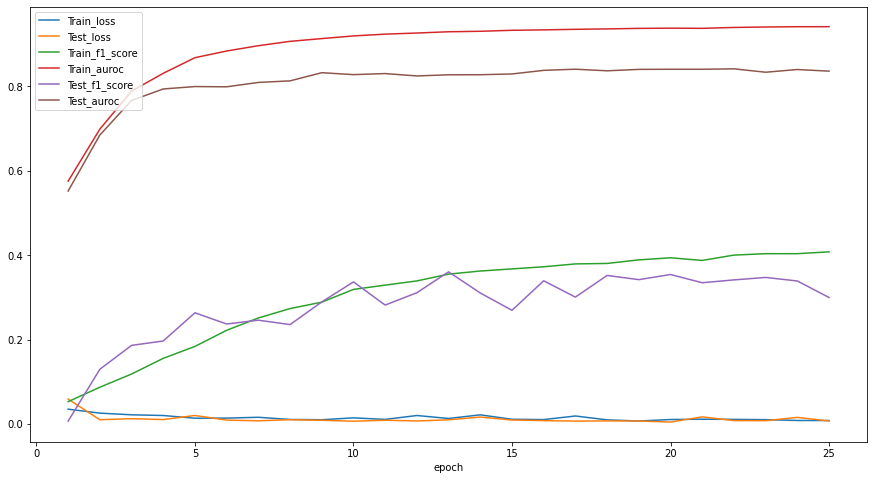

In [ ]:
#plot all the values for the model trained on the crackforest dataset 
df.plot(x='epoch',figsize=(15,8));

In [ ]:
df

,epoch,Train_loss,Test_loss,Train_f1_score,Train_auroc,Test_f1_score,Test_auroc
0,1,0.035657,0.059498,0.053392,0.575316,0.007171,0.551993
1,2,0.026265,0.010668,0.087540,0.698408,0.130032,0.684543
2,3,0.022293,0.013077,0.118785,0.788395,0.186619,0.766347
3,4,0.020628,0.011009,0.155929,0.830701,0.197023,0.793637
4,5,0.014172,0.020693,0.184165,0.867632,0.263790,0.799297
5,6,0.014511,0.009775,0.222335,0.883487,0.237241,0.798730
6,7,0.016424,0.008076,0.251476,0.896012,0.246315,0.809054
7,8,0.011271,0.010690,0.273721,0.906346,0.235823,0.812781
8,9,0.010645,0.009322,0.288928,0.912871,0.289377,0.832147
9,10,0.015031,0.007070,0.319131,0.919163,0.336884,0.827553


In [ ]:
print(df[['Train_auroc','Test_auroc']].max())

Train_auroc    0.941044
Test_auroc     0.841288
dtype: float64


#Sample Prediction

In [ ]:
import cv2
ino = 2
# Read  a sample image and mask from the data-set
img = cv2.imread(f'./CrackForest/Images/{ino:03d}.jpg').transpose(2,0,1).reshape(1,3,320,480)
mask = cv2.imread(f'./CrackForest/Masks/{ino:03d}_label.PNG')
with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255)

(array([2.3900e+02, 8.9960e+03, 1.3054e+05, 4.8480e+03, 4.1610e+03,
        2.6080e+03, 1.4540e+03, 5.4700e+02, 1.7900e+02, 2.8000e+01]),
 array([-0.33107617, -0.1827052 , -0.03433421,  0.11403678,  0.26240775,
         0.41077876,  0.55914974,  0.7075207 ,  0.8558917 ,  1.0042627 ,
         1.1526337 ], dtype=float32),
 <a list of 10 Patch objects>)

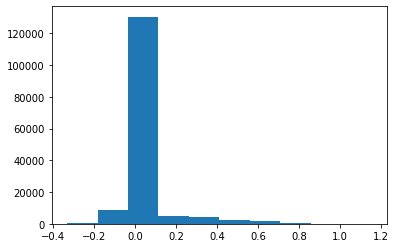

In [ ]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
import matplotlib.pyplot as plt
plt.hist(a['out'].data.cpu().numpy().flatten())

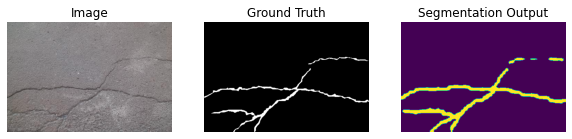

In [ ]:

# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(a['out'].cpu().detach().numpy()[0][0]>0.2);
plt.title('Segmentation Output')
plt.axis('off');
plt.savefig('./CFExp/SegmentationOutput.png',bbox_inches='tight')